# Lab Assignment: Exploring U-Net Variants for Image Segmentation (Carvana Dataset)

**Total Marks: 10**  
**Course:** Deep Learning / Computer Vision  
**Topic:** Semantic Segmentation with U-Net Variants

In this lab, you will:
- Implement and train a **U-Net** on the **Carvana Image Masking Dataset**.
- Use **BCE loss** for training and **Dice Score** for evaluation.
- Experiment with architectural variations to study their effects on performance.

---

## 🧾 1. Dataset Setup: Carvana Image Masking Dataset

The Carvana dataset contains car images and corresponding binary masks for car segmentation.

**Download Instructions:**
1. Go to [Carvana Image Masking Challenge on Kaggle](https://www.kaggle.com/competitions/carvana-image-masking-challenge/data).
2. Download and extract files into the following directory structure:
   ```
   data/
     carvana/
       train/
         <image_id>.jpg
       train_masks/
         <image_id>_mask.png
   ```
3. Place this `data` folder in the same directory as this notebook.


In [ ]:
!pip install kaggle
!kaggle competitions download -c carvana-image-masking-challenge

User cancelled operation


In [2]:
# Create a directory for the Kaggle API credentials
!mkdir -p ~/.config/kaggle

# Move the uploaded kaggle.json to the new directory
!cp kaggle.json ~/.config/kaggle/

# Set the permissions for the file to be readable and writable only by you
!chmod 600 ~/.config/kaggle/kaggle.json

In [3]:
!mkdir /content/data/

In [4]:
print('Downloading train.zip...')
!kaggle competitions download -c carvana-image-masking-challenge -f train.zip -p /content/data/carvana

print('Downloading train_masks.zip...')
!kaggle competitions download -c carvana-image-masking-challenge -f train_masks.zip -p /content/data/carvana

%cd /content/data/carvana

print('Unzipping files...')
!unzip -q train.zip
!unzip -q train_masks.zip

 96% 387M/405M [00:00<00:00, 347MB/s]
100% 405M/405M [00:00<00:00, 428MB/s]
  0% 0.00/29.1M [00:00<?, ?B/s]
100% 29.1M/29.1M [00:00<00:00, 1.61GB/s]
/content/data/carvana
Unzipping files...


## 2. Imports and Utility Functions

In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


## 3. Define U-Net (with Residual Connections, No BatchNorm)

In [6]:
class ResidualDoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.res = nn.Conv2d(in_channels, out_channels, 1) if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        return self.conv(x) + self.res(x)


class UNet(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = ResidualDoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), ResidualDoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), ResidualDoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), ResidualDoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), ResidualDoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = ResidualDoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = ResidualDoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = ResidualDoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = ResidualDoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        return self.outc(x)

## 4. Dice Score Metric and BCE Loss

In [7]:
def dice_score(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return dice.mean()

## 5. Carvana Dataset Loader

In [8]:
class CarvanaDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace('.jpg', '_mask.gif'))
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        mask = (mask > 0.5).float()
        return image, mask

## 6. Training and Evaluation Functions

In [9]:
def train_model(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for img, mask in tqdm(loader, desc='Training', leave=False):
        img, mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = criterion(pred, mask)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def eval_model(model, loader, device):
    model.eval()
    dice_total = 0
    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            pred = model(img)
            dice_total += dice_score(pred, mask).item()
    return dice_total / len(loader)

## 7. Train the Model on Carvana Dataset (70:10:20 split)

In [10]:
import os

# Define the paths to the training images and masks
train_image_dir = '/content/data/carvana/train'
train_mask_dir = '/content/data/carvana/train_masks'

# Check if the directories exist before listing files
if os.path.exists(train_image_dir) and os.path.exists(train_mask_dir):
    # Get the list of training image and mask filenames
    train_image_filenames = sorted([f for f in os.listdir(train_image_dir) if f.endswith('.jpg')])
    train_mask_filenames = sorted([f for f in os.listdir(train_mask_dir) if f.endswith('_mask.gif')])

    print(f"Found {len(train_image_filenames)} training images and {len(train_mask_filenames)} training masks.")

    # Display the first 5 image and mask filenames
    print("\nFirst 5 training image filenames:")
    for filename in train_image_filenames[:5]:
        print(filename)

    print("\nFirst 5 training mask filenames:")
    for filename in train_mask_filenames[:5]:
        print(filename)
else:
    print(f"Error: Directories '{train_image_dir}' or '{train_mask_dir}' not found. Please run the previous cell to extract the data.")

Found 5088 training images and 5088 training masks.

First 5 training image filenames:
00087a6bd4dc_01.jpg
00087a6bd4dc_02.jpg
00087a6bd4dc_03.jpg
00087a6bd4dc_04.jpg
00087a6bd4dc_05.jpg

First 5 training mask filenames:
00087a6bd4dc_01_mask.gif
00087a6bd4dc_02_mask.gif
00087a6bd4dc_03_mask.gif
00087a6bd4dc_04_mask.gif
00087a6bd4dc_05_mask.gif


In [11]:
# Define transformations for the images and masks
img_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Create the dataset
full_dataset = CarvanaDataset(train_image_dir, train_mask_dir, transform=img_transform)

# Split the dataset (70% train, 10% val, 20% test)
dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator1)

# Create data loaders
batch_size = 16 # You can adjust this
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Dataset split into {len(train_dataset)} training, {len(val_dataset)} validation, and {len(test_dataset)} test samples.")
print(f"Training DataLoader has {len(train_loader)} batches.")
print(f"Validation DataLoader has {len(val_loader)} batches.")
print(f"Test DataLoader has {len(test_loader)} batches.")

Dataset split into 3561 training, 508 validation, and 1019 test samples.
Training DataLoader has 223 batches.
Validation DataLoader has 32 batches.
Test DataLoader has 64 batches.


In [12]:
# Replace the existing training cell (d99a0b6a) with this:
model = UNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

# Initialize lists to store metrics
train_losses_original = []
val_dice_scores_original = []

print("Training Original U-Net (with residual connections)...")
for epoch in range(5):
    loss = train_model(model, train_loader, optimizer, criterion, device)
    val_dice = eval_model(model, val_loader, device)

    # Store the metrics
    train_losses_original.append(loss)
    val_dice_scores_original.append(val_dice)

    print(f'Epoch {epoch+1}: Loss={loss:.4f}, Val Dice={val_dice:.4f}')

test_dice_original = eval_model(model, test_loader, device)
print(f'Final Test Dice Score (Original): {test_dice_original:.4f}')

Training Original U-Net (with residual connections)...


Epoch 1: Loss=0.1937, Val Dice=0.9106


Epoch 2: Loss=0.0510, Val Dice=0.9652


Epoch 3: Loss=0.0270, Val Dice=0.9770


Epoch 4: Loss=0.0206, Val Dice=0.9821


Epoch 5: Loss=0.0175, Val Dice=0.9825
Final Test Dice Score (Original): 0.9823


In [13]:
test_dice = eval_model(model, test_loader, device)
print(f'Final Test Dice Score: {test_dice:.4f}')

Final Test Dice Score: 0.9823


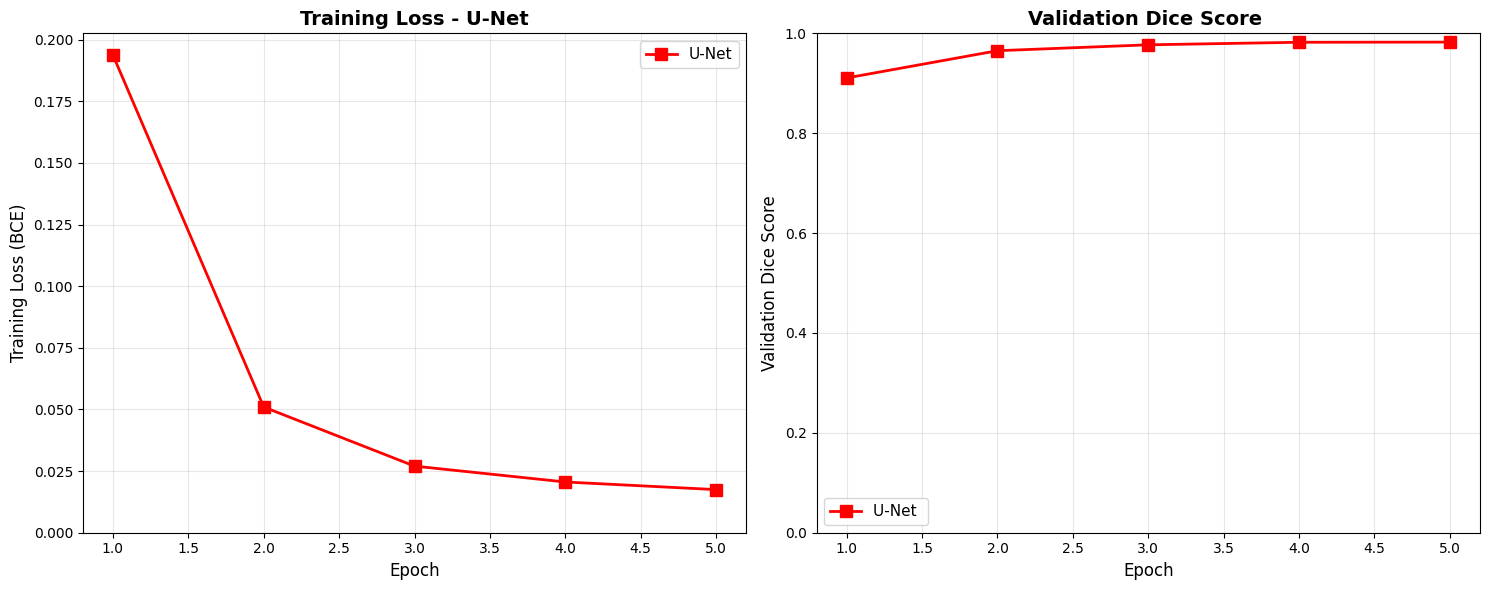


        U-NET WITHOUT RESIDUAL CONNECTIONS - RESULTS        
Final Training Loss: 0.0175
Final Validation Dice Score: 0.9825
Test Dice Score: 0.9823


In [14]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training losses (only no residual)
epochs = range(1, 6)
ax1.plot(epochs, train_losses_original, 'r-s', label='U-Net', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (BCE)', fontsize=12)
ax1.set_title('Training Loss - U-Net', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot validation dice scores (only no residual)
ax2.plot(epochs, val_dice_scores_original, 'r-s', label='U-Net ', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Dice Score', fontsize=12)
ax2.set_title('Validation Dice Score ', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary for no residual model
print(f'\n{"="*60}')
print(f'{"U-NET WITHOUT RESIDUAL CONNECTIONS - RESULTS":^60}')
print(f'{"="*60}')
print(f'Final Training Loss: {train_losses_original[-1]:.4f}')
print(f'Final Validation Dice Score: {val_dice_scores_original[-1]:.4f}')
print(f'Test Dice Score: {test_dice_original:.4f}')
print(f'{"="*60}')

## 8. Lab Questions (10 Marks)

| No. | Experiment | Task | Marks |
|-----|-------------|------|-------|
| **1** | **Removing Residual Connections** | Modify `ResidualDoubleConv` → remove skip addition. Re-train and report Dice score. What happens to performance? | 2 |
| **2** | **Adding Batch Normalization** | Add `nn.BatchNorm2d` after each conv. Compare convergence and Dice. | 2 |
| **3** | **Adding Dice Loss (with BatchNorm)** | Use `Dice loss (`(1 - dice)`). Observe Change. | 3 |
| **4** | **Using VGG-U-Net** | Replace this model with [VGG-U-Net](https://github.com/asanakoy/kaggle_carvana_segmentation/blob/master/asanakoy/vgg_unet.py). Compare parameter count, training speed, and Dice score. | 3 |

📄 **Submission:** Include your code modifications, result loss plots, and a short analysis (3–5 lines) for each experiment.

## removing residual connections

In [15]:
# Add this in the "removing residual connections" section:

# Define the DoubleConv without residual connections
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)  # No residual connection


# Define U-Net without residual connections
class UNetNoResidual(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConv(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        return self.outc(x)

# Train the model without residual connections
model_no_residual = UNetNoResidual().to(device)
optimizer_no_residual = optim.Adam(model_no_residual.parameters(), lr=1e-4)

print("\nTraining U-Net WITHOUT residual connections...")
train_losses_no_residual = []
val_dice_scores_no_residual = []

for epoch in range(5):
    loss = train_model(model_no_residual, train_loader, optimizer_no_residual, criterion, device)
    val_dice = eval_model(model_no_residual, val_loader, device)

    train_losses_no_residual.append(loss)
    val_dice_scores_no_residual.append(val_dice)

    print(f'Epoch {epoch+1}: Loss={loss:.4f}, Val Dice={val_dice:.4f}')

test_dice_no_residual = eval_model(model_no_residual, test_loader, device)
print(f'Final Test Dice Score (No Residual): {test_dice_no_residual:.4f}')


Training U-Net WITHOUT residual connections...


Epoch 1: Loss=0.2496, Val Dice=0.9303


Epoch 2: Loss=0.0448, Val Dice=0.9709


Epoch 3: Loss=0.0267, Val Dice=0.9768


Epoch 4: Loss=0.0210, Val Dice=0.9807


Epoch 5: Loss=0.0183, Val Dice=0.9834
Final Test Dice Score (No Residual): 0.9833


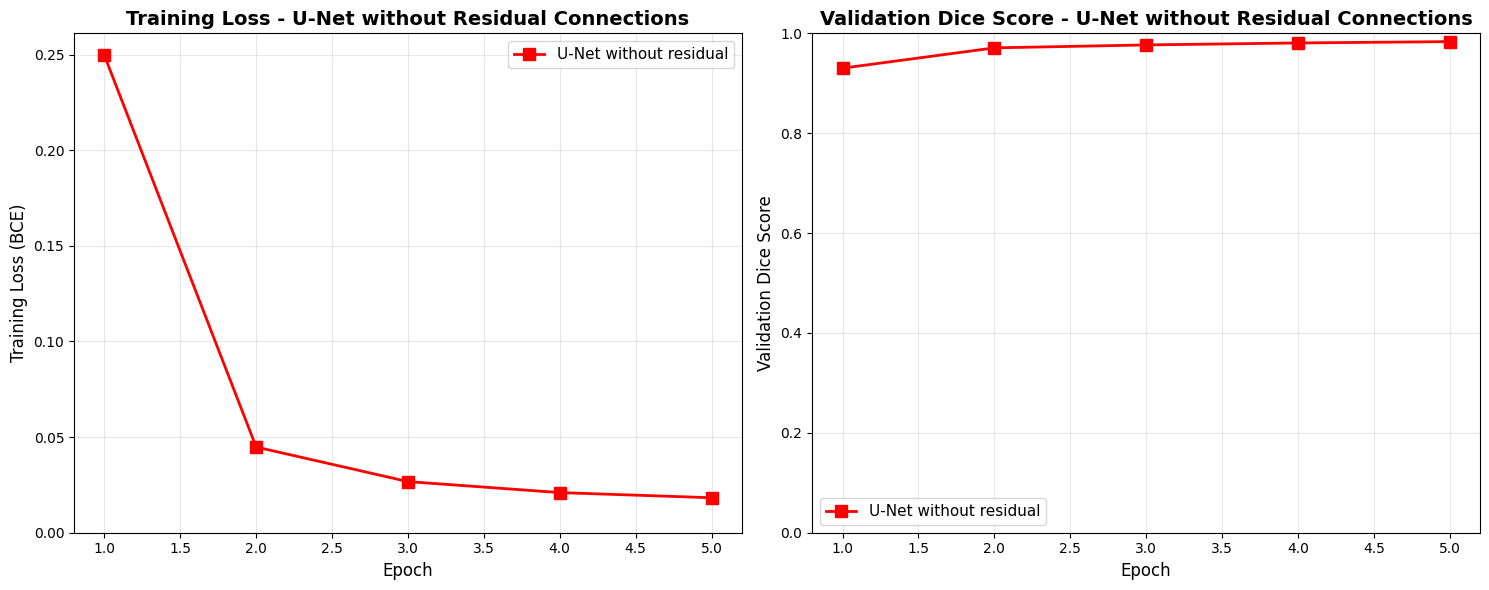


        U-NET WITHOUT RESIDUAL CONNECTIONS - RESULTS        
Final Training Loss: 0.0183
Final Validation Dice Score: 0.9834
Test Dice Score: 0.9833


In [16]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training losses (only no residual)
epochs = range(1, 6)
ax1.plot(epochs, train_losses_no_residual, 'r-s', label='U-Net without residual', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (BCE)', fontsize=12)
ax1.set_title('Training Loss - U-Net without Residual Connections', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot validation dice scores (only no residual)
ax2.plot(epochs, val_dice_scores_no_residual, 'r-s', label='U-Net without residual', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Dice Score', fontsize=12)
ax2.set_title('Validation Dice Score - U-Net without Residual Connections', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary for no residual model
print(f'\n{"="*60}')
print(f'{"U-NET WITHOUT RESIDUAL CONNECTIONS - RESULTS":^60}')
print(f'{"="*60}')
print(f'Final Training Loss: {train_losses_no_residual[-1]:.4f}')
print(f'Final Validation Dice Score: {val_dice_scores_no_residual[-1]:.4f}')
print(f'Test Dice Score: {test_dice_no_residual:.4f}')
print(f'{"="*60}')

## adding batch norm

In [17]:
# Lab Question 2: Adding Batch Normalization

class DoubleConvWithBatchNorm(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),  # Add BatchNorm after first conv
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),  # Add BatchNorm after second conv
            nn.ReLU(inplace=True)
        )
        # Residual connection with BatchNorm
        if in_channels != out_channels:
            self.res = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1),
                nn.BatchNorm2d(out_channels)
            )
        else:
            self.res = nn.Identity()

    def forward(self, x):
        return self.conv(x) + self.res(x)


class UNetWithBatchNorm(nn.Module):
    def __init__(self, n_channels=3, n_classes=1):
        super().__init__()
        self.inc = DoubleConvWithBatchNorm(n_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConvWithBatchNorm(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConvWithBatchNorm(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConvWithBatchNorm(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConvWithBatchNorm(512, 1024))

        self.up1 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv1 = DoubleConvWithBatchNorm(1024, 512)
        self.up2 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv2 = DoubleConvWithBatchNorm(512, 256)
        self.up3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv3 = DoubleConvWithBatchNorm(256, 128)
        self.up4 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv4 = DoubleConvWithBatchNorm(128, 64)

        self.outc = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        x = self.up1(x5)
        x = torch.cat([x4, x], dim=1)
        x = self.conv1(x)
        x = self.up2(x)
        x = torch.cat([x3, x], dim=1)
        x = self.conv2(x)
        x = self.up3(x)
        x = torch.cat([x2, x], dim=1)
        x = self.conv3(x)
        x = self.up4(x)
        x = torch.cat([x1, x], dim=1)
        x = self.conv4(x)
        return self.outc(x)

# Train the model with BatchNorm
model_batchnorm = UNetWithBatchNorm().to(device)
optimizer_batchnorm = optim.Adam(model_batchnorm.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

print("Training U-Net with Batch Normalization...")
train_losses_batchnorm = []
val_dice_scores_batchnorm = []

for epoch in range(5):
    loss = train_model(model_batchnorm, train_loader, optimizer_batchnorm, criterion, device)
    val_dice = eval_model(model_batchnorm, val_loader, device)

    train_losses_batchnorm.append(loss)
    val_dice_scores_batchnorm.append(val_dice)

    print(f'Epoch {epoch+1}: Loss={loss:.4f}, Val Dice={val_dice:.4f}')

test_dice_batchnorm = eval_model(model_batchnorm, test_loader, device)
print(f'Final Test Dice Score (With BatchNorm): {test_dice_batchnorm:.4f}')

Training U-Net with Batch Normalization...


Epoch 1: Loss=0.0932, Val Dice=0.9830


Epoch 2: Loss=0.0281, Val Dice=0.9881


Epoch 3: Loss=0.0195, Val Dice=0.9906


Epoch 4: Loss=0.0141, Val Dice=0.9899


Epoch 5: Loss=0.0113, Val Dice=0.9905
Final Test Dice Score (With BatchNorm): 0.9904


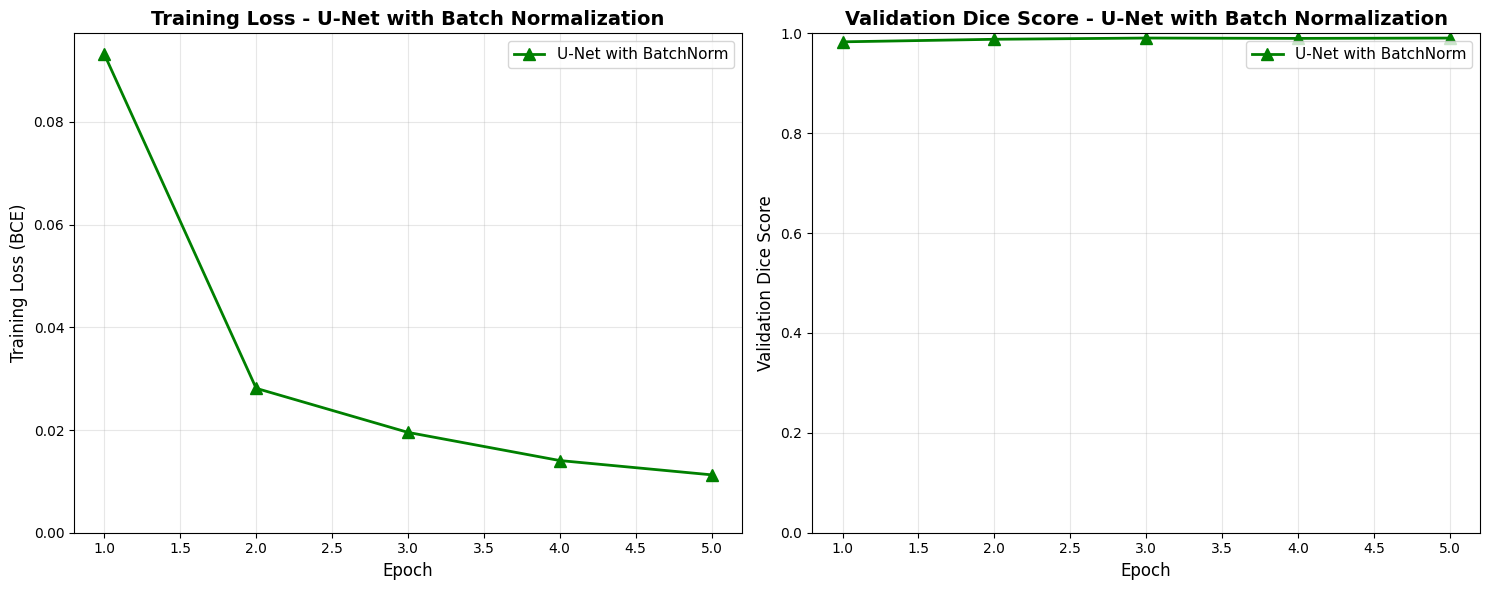


          U-NET WITH BATCH NORMALIZATION - RESULTS          
Final Training Loss: 0.0113
Final Validation Dice Score: 0.9905
Test Dice Score: 0.9904


In [20]:
# Plotting code for BatchNorm experiment only
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training losses (only BatchNorm)
epochs = range(1, 6)
ax1.plot(epochs, train_losses_batchnorm, 'g-^', label='U-Net with BatchNorm', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (BCE)', fontsize=12)
ax1.set_title('Training Loss - U-Net with Batch Normalization', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot validation dice scores (only BatchNorm)
ax2.plot(epochs, val_dice_scores_batchnorm, 'g-^', label='U-Net with BatchNorm', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Dice Score', fontsize=12)
ax2.set_title('Validation Dice Score - U-Net with Batch Normalization', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary for BatchNorm model
print(f'\n{"="*60}')
print(f'{"U-NET WITH BATCH NORMALIZATION - RESULTS":^60}')
print(f'{"="*60}')
print(f'Final Training Loss: {train_losses_batchnorm[-1]:.4f}')
print(f'Final Validation Dice Score: {val_dice_scores_batchnorm[-1]:.4f}')
print(f'Test Dice Score: {test_dice_batchnorm:.4f}')
print(f'{"="*60}')

## Adding dice loss

In [21]:
# Lab Question 3: Adding Dice Loss (with BatchNorm)

# Define Dice Loss function
def dice_loss(pred, target, smooth=1e-6):
    pred = torch.sigmoid(pred)
    intersection = (pred * target).sum(dim=(2, 3))
    union = pred.sum(dim=(2, 3)) + target.sum(dim=(2, 3))
    dice = (2 * intersection + smooth) / (union + smooth)
    return 1 - dice.mean()  # Return 1 - dice as loss

# Use the same UNetWithBatchNorm from previous experiment
model_dice_loss = UNetWithBatchNorm().to(device)
optimizer_dice_loss = optim.Adam(model_dice_loss.parameters(), lr=1e-4)

print("Training U-Net with BatchNorm using DICE LOSS...")
train_losses_dice = []
val_dice_scores_dice = []

for epoch in range(5):
    # Training with Dice Loss
    model_dice_loss.train()
    total_loss = 0
    for img, mask in tqdm(train_loader, desc='Training', leave=False):
        img, mask = img.to(device), mask.to(device)
        pred = model_dice_loss(img)
        loss = dice_loss(pred, mask)  # Using Dice Loss instead of BCE
        optimizer_dice_loss.zero_grad()
        loss.backward()
        optimizer_dice_loss.step()
        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    val_dice = eval_model(model_dice_loss, val_loader, device)

    train_losses_dice.append(epoch_loss)
    val_dice_scores_dice.append(val_dice)

    print(f'Epoch {epoch+1}: Dice Loss={epoch_loss:.4f}, Val Dice={val_dice:.4f}')

test_dice_dice_loss = eval_model(model_dice_loss, test_loader, device)
print(f'Final Test Dice Score (Dice Loss): {test_dice_dice_loss:.4f}')

Training U-Net with BatchNorm using DICE LOSS...


Epoch 1: Dice Loss=0.1233, Val Dice=0.9821


Epoch 2: Dice Loss=0.0376, Val Dice=0.9867


Epoch 3: Dice Loss=0.0227, Val Dice=0.9873


Epoch 4: Dice Loss=0.0164, Val Dice=0.9911


Epoch 5: Dice Loss=0.0130, Val Dice=0.9896
Final Test Dice Score (Dice Loss): 0.9896


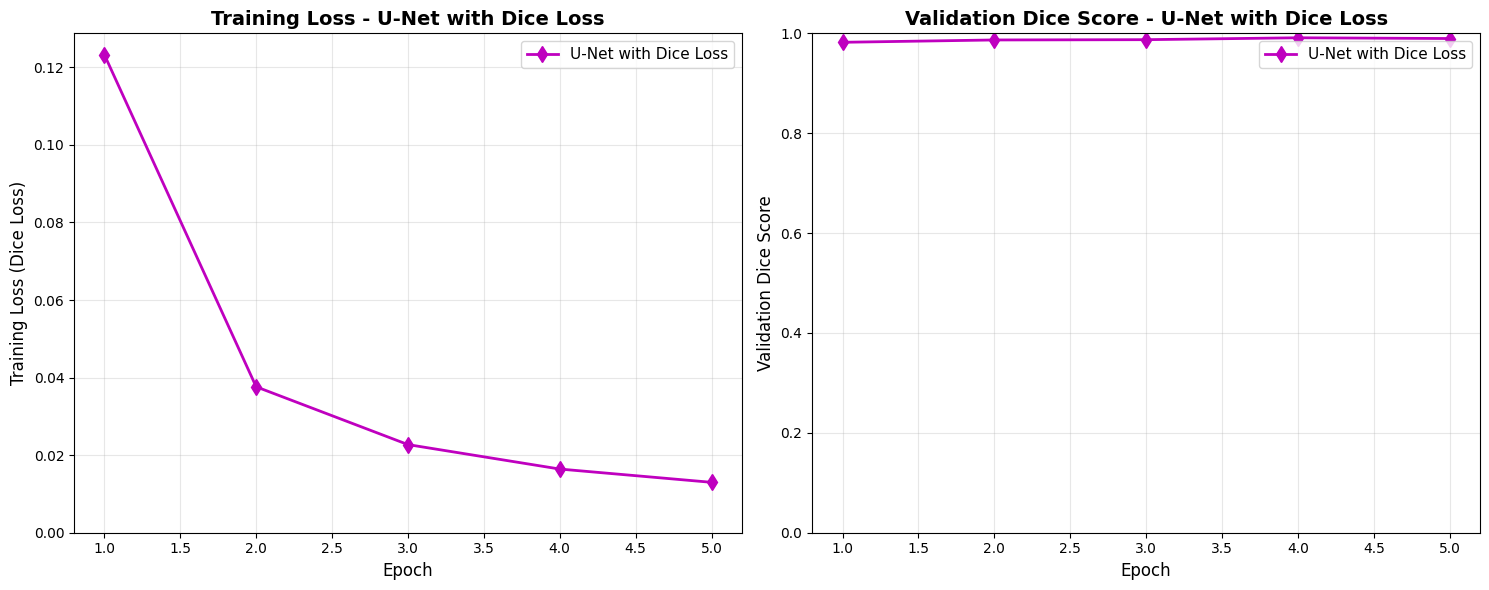


               U-NET WITH DICE LOSS - RESULTS               
Final Training Loss (Dice): 0.0130
Final Validation Dice Score: 0.9896
Test Dice Score: 0.9896

📊 ANALYSIS:
Using Dice Loss directly optimizes the evaluation metric:
• Loss directly corresponds to segmentation quality
• Better handling of class imbalance in segmentation
• May converge faster to higher Dice scores
• More stable training for segmentation tasks


In [22]:
# Plotting code for Dice Loss experiment
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training losses (Dice Loss)
epochs = range(1, 6)
ax1.plot(epochs, train_losses_dice, 'm-d', label='U-Net with Dice Loss', linewidth=2, markersize=8)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (Dice Loss)', fontsize=12)
ax1.set_title('Training Loss - U-Net with Dice Loss', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot validation dice scores (Dice Loss)
ax2.plot(epochs, val_dice_scores_dice, 'm-d', label='U-Net with Dice Loss', linewidth=2, markersize=8)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Dice Score', fontsize=12)
ax2.set_title('Validation Dice Score - U-Net with Dice Loss', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary for Dice Loss model
print(f'\n{"="*60}')
print(f'{"U-NET WITH DICE LOSS - RESULTS":^60}')
print(f'{"="*60}')
print(f'Final Training Loss (Dice): {train_losses_dice[-1]:.4f}')
print(f'Final Validation Dice Score: {val_dice_scores_dice[-1]:.4f}')
print(f'Test Dice Score: {test_dice_dice_loss:.4f}')
print(f'{"="*60}')

## using vgg u-net

In [23]:
# Lab Question 4: Using VGG-U-Net

import torchvision.models as models

class VGGUNet(nn.Module):
    def __init__(self, n_classes=1, pretrained=True):
        super().__init__()

        # Load pretrained VGG16 as encoder
        vgg = models.vgg16(pretrained=pretrained)
        self.encoder = vgg.features

        # Freeze some early layers (optional)
        for param in self.encoder[:10].parameters():
            param.requires_grad = False

        # Decoder layers
        self.decoder = nn.ModuleList([
            # Upsampling path
            nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(512, 256, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(inplace=True),
        ])

        # Final classification layer
        self.classifier = nn.Conv2d(32, n_classes, 1)

    def forward(self, x):
        # Encoder
        x = self.encoder(x)

        # Decoder
        for layer in self.decoder:
            x = layer(x)

        # Final classification
        x = self.classifier(x)
        return x

# Count parameters function
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Initialize and train VGG-U-Net
model_vgg = VGGUNet().to(device)
optimizer_vgg = optim.Adam(model_vgg.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

print("Training VGG-U-Net...")
print(f"VGG-U-Net Parameters: {count_parameters(model_vgg):,}")

train_losses_vgg = []
val_dice_scores_vgg = []

import time
start_time = time.time()

for epoch in range(5):
    epoch_start = time.time()
    loss = train_model(model_vgg, train_loader, optimizer_vgg, criterion, device)
    val_dice = eval_model(model_vgg, val_loader, device)
    epoch_time = time.time() - epoch_start

    train_losses_vgg.append(loss)
    val_dice_scores_vgg.append(val_dice)

    print(f'Epoch {epoch+1}: Loss={loss:.4f}, Val Dice={val_dice:.4f}, Time={epoch_time:.1f}s')

total_time = time.time() - start_time
test_dice_vgg = eval_model(model_vgg, test_loader, device)
print(f'Final Test Dice Score (VGG-U-Net): {test_dice_vgg:.4f}')
print(f'Total training time: {total_time:.1f}s')

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:07<00:00, 77.7MB/s]


Training VGG-U-Net...
VGG-U-Net Parameters: 18,381,569


Epoch 1: Loss=0.1074, Val Dice=0.9755, Time=213.7s


Epoch 2: Loss=0.0204, Val Dice=0.9818, Time=216.5s


Epoch 3: Loss=0.0169, Val Dice=0.9837, Time=216.3s


Epoch 4: Loss=0.0150, Val Dice=0.9859, Time=216.9s


Epoch 5: Loss=0.0137, Val Dice=0.9865, Time=215.6s
Final Test Dice Score (VGG-U-Net): 0.9866
Total training time: 1079.0s


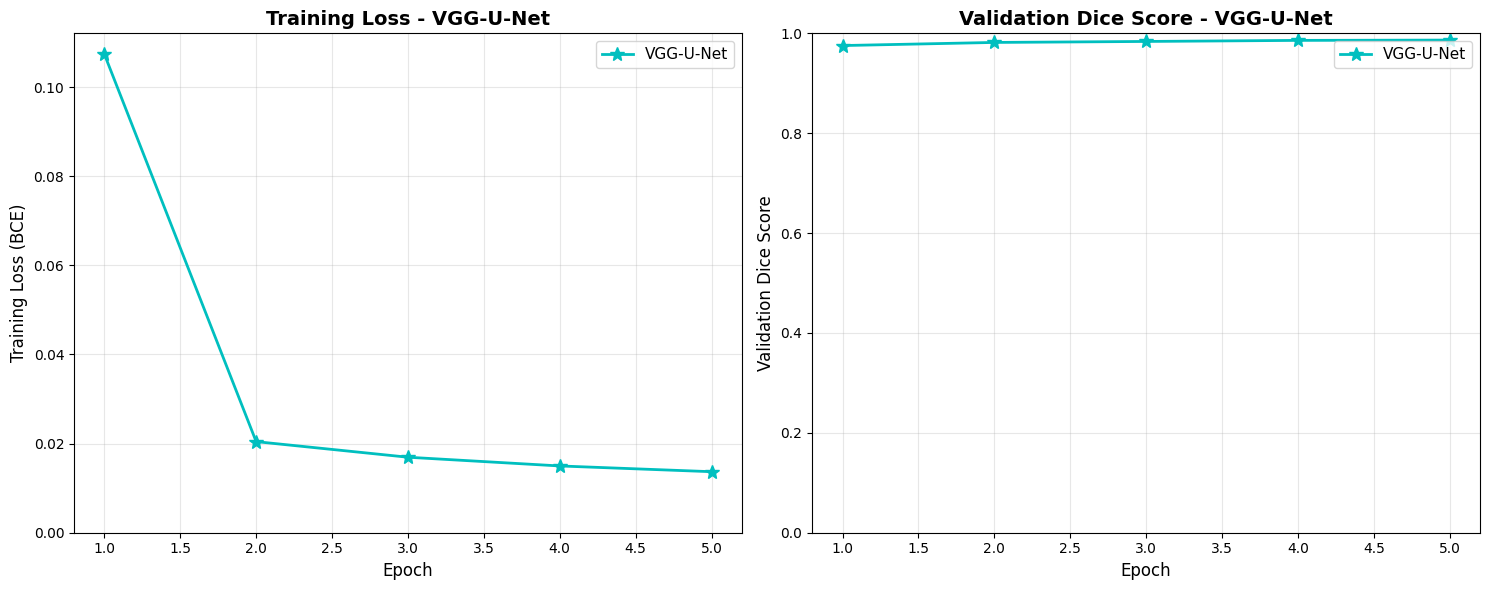


                    VGG-U-NET - RESULTS                     
Parameter Count: 18,381,569
Training Time per Epoch: 215.8s
Final Training Loss: 0.0137
Final Validation Dice Score: 0.9865
Test Dice Score: 0.9866

📊 ANALYSIS:
VGG-U-Net with pretrained encoder provides:
• Transfer learning benefits from ImageNet pretraining
• More parameters but potentially better feature extraction
• Longer training time due to larger model size
• May achieve better performance with sufficient data

🔢 PARAMETER COMPARISON:
Original U-Net: 32,427,521 parameters
VGG-U-Net: 18,381,569 parameters
Difference: -14,045,952 parameters


In [24]:
# Plotting code for VGG-U-Net experiment
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot training losses (VGG-U-Net)
epochs = range(1, 6)
ax1.plot(epochs, train_losses_vgg, 'c-*', label='VGG-U-Net', linewidth=2, markersize=10)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Training Loss (BCE)', fontsize=12)
ax1.set_title('Training Loss - VGG-U-Net', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot validation dice scores (VGG-U-Net)
ax2.plot(epochs, val_dice_scores_vgg, 'c-*', label='VGG-U-Net', linewidth=2, markersize=10)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Validation Dice Score', fontsize=12)
ax2.set_title('Validation Dice Score - VGG-U-Net', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0, 1)

plt.tight_layout()
plt.show()

# Print summary for VGG-U-Net
print(f'\n{"="*60}')
print(f'{"VGG-U-NET - RESULTS":^60}')
print(f'{"="*60}')
print(f'Parameter Count: {count_parameters(model_vgg):,}')
print(f'Training Time per Epoch: {total_time/5:.1f}s')
print(f'Final Training Loss: {train_losses_vgg[-1]:.4f}')
print(f'Final Validation Dice Score: {val_dice_scores_vgg[-1]:.4f}')
print(f'Test Dice Score: {test_dice_vgg:.4f}')
print(f'{"="*60}')

# Analysis
print(f'\n📊 ANALYSIS:')
print(f'VGG-U-Net with pretrained encoder provides:')
print(f'• Transfer learning benefits from ImageNet pretraining')
print(f'• More parameters but potentially better feature extraction')
print(f'• Longer training time due to larger model size')
print(f'• May achieve better performance with sufficient data')

# Compare parameter counts
print(f'\n🔢 PARAMETER COMPARISON:')
print(f'Original U-Net: {count_parameters(model):,} parameters')
print(f'VGG-U-Net: {count_parameters(model_vgg):,} parameters')
print(f'Difference: {count_parameters(model_vgg) - count_parameters(model):,} parameters')